# Ensembled Temperature Predictor

In [1]:
import gc
import logging
import os
from typing import Iterable

import gsod
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyeemd as eemd
import tensorflow as tf
from absl import logging as alogger
from matplotlib_inline.backend_inline import set_matplotlib_formats
from tensorflow.python.data.ops.dataset_ops import MapDataset

# SVG Graphing
set_matplotlib_formats("svg")
# Suppress TensorFlow logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.get_logger().setLevel(logging.FATAL)
alogger.set_verbosity(alogger.FATAL)

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
STATION = "722860"
ds = gsod.GsodDataset("/tmp/GSOD")
interpolated = ds.read_continuous(stn=STATION, year="????", interpolate=True)
interpolated.describe().T

imfs_array = eemd.ceemdan(interpolated["TEMP"])
imfs = pd.DataFrame(imfs_array.T,
                    columns=[f"IMF {n+1}" for n in range(len(imfs_array))])
imfs.index = interpolated.index
dataframe = pd.merge(interpolated, imfs, how="left",
                     left_index=True, right_index=True)
imfs.describe().T

,count,mean,std,min,25%,50%,75%,max
IMF 1,32353.0,-0.009430,1.445604,-8.087523,-0.937529,-0.013539,0.892774,7.803147
IMF 2,32353.0,-0.000710,0.226400,-1.986657,-0.147704,-0.002119,0.144548,2.557312
IMF 3,32353.0,-0.002454,1.171615,-6.026996,-0.733010,-0.013655,0.721976,5.444142
IMF 4,32353.0,-0.007266,1.717885,-9.450906,-1.154699,-0.017321,1.131476,9.775368
IMF 5,32353.0,-0.007274,1.716266,-7.401238,-1.194221,-0.019496,1.175146,6.731860
IMF 6,32353.0,-0.005901,1.587129,-5.786507,-1.135891,0.000732,1.119851,5.955110
IMF 7,32353.0,-0.003076,1.449131,-4.943888,-1.025639,-0.001348,1.046936,5.523331
IMF 8,32353.0,0.002960,1.185140,-4.647451,-0.801599,-0.004280,0.826147,4.903218
IMF 9,32353.0,-0.618600,6.772349,-13.748307,-6.355380,-1.847897,5.554219,14.069952
IMF 10,32353.0,-0.030497,2.982550,-7.628524,-2.406159,-0.043325,2.330340,6.980427


Load pre-trained models from the disk.

In [3]:
mp = "/tmp"
def get_models():
     return (tf.keras.models.load_model(f"{mp}/IMF {i + 1}") for i in range(len(imfs.T) - 1))

In [4]:
def predict_temperature(prev_imfs, models: Iterable[tf.keras.Model]) -> float:
    """Predict a single temperature from a window.
    
    Parameters
    ----------
        prev_imfs: (n_imfs, window_width) IMFs.
        models: List of models for each imf.
        
    Returns
    -------
    float
        Prediction.
    """
    result = 0.0
    for imf, model in zip(prev_imfs, models):
        model_input = imf.reshape(1, -1, 1)
        result += model(model_input)[0, -1, 0]
    return result

def batch_predict_temperature(
    imfs,
    models: Iterable[tf.keras.Model],
    *,
    window_width: int = 7,
    n_predictions: int = -1
):
    """Predict a single temperature from a window.
    
    Parameters
    ----------
        imfs: (n_imfs, n_predictions + window_width - 1) IMFs for predictions.
              If the length of the second dimension is larger, the extra ones
              at the front will be ignored.
        models: List of models for each imf.
        window_width: width of the window.
        n_predictions: number of predictions to make. Default of -1 for all.
        
    Returns
    -------
    NDArray[float]
        Predictions.
    """
    # Reset n_predictions for all
    if n_predictions < 0:
        n_predictions = imfs.shape[1] + 1 - window_width
    # Pre-allocate array
    result = np.zeros(n_predictions)
    for imf, model in zip(imfs, models):
        imf_to_use = imf[-(n_predictions + window_width - 1):]
        window = gsod.sliding_window(imf_to_use, window_width)
        # Add each IMF's result to the prediction
        result += model.predict(
            window.reshape(-1, window_width, 1)
        # window_width - shift
        )[:, window_width - 1, 0]
        tf.keras.backend.clear_session()
        gc.collect()
    return result

In [5]:
with tf.device("/cpu:0"):
    result = batch_predict_temperature(np.asarray(imfs.T)[:-1], get_models())

Metal device set to: Apple M1


In [6]:
# The last temperature is the future
prediction = result[:-1] + imfs["IMF 14"][7:]
actual = np.asarray(interpolated["TEMP"])[7:]
indices = interpolated.index[7:]

Text(0, -50, 'MAE: 0.7399${}^\\circ$F\nRMSE: 0.9703${}^\\circ$F')

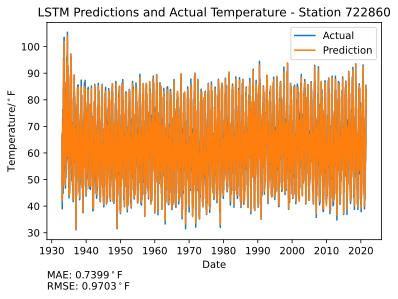

In [7]:
plt.plot(indices, actual, label="Actual")
plt.plot(indices, prediction, label="Prediction")
plt.legend()
plt.title(f"LSTM Predictions and Actual Temperature - Station {STATION}")
plt.xlabel("Date")
plt.ylabel("Temperature/${}^\circ$F")
plt.annotate(
    f"MAE: {np.average(np.abs(prediction - actual)):0.4}${{}}^\circ$F\n"
    + f"RMSE: {np.average((prediction - actual)**2)**0.5:0.4}${{}}^\circ$F",
    (0, -50),
    xycoords="axes points"
)

Text(0, -50, 'MAE: 0.6936${}^\\circ$F\nRMSE: 0.8896${}^\\circ$F')

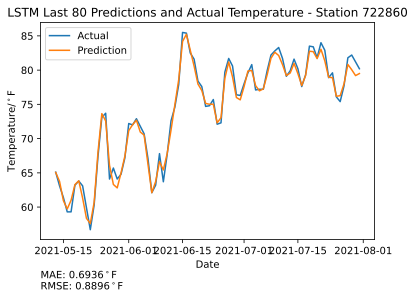

In [8]:
plt.plot(indices[-80:], actual[-80:], label="Actual")
plt.plot(indices[-80:], prediction[-80:], label="Prediction")
plt.legend()
plt.title(f"LSTM Last 80 Predictions and Actual Temperature - Station {STATION}")
plt.xlabel("Date")
plt.ylabel("Temperature/${}^\circ$F")
plt.annotate(
    f"MAE: {np.average(np.abs(prediction[-80:] - actual[-80:])):0.4}${{}}^\circ$F\n"
    + f"RMSE: {np.average((prediction[-80:] - actual[-80:])**2)**0.5:0.4}${{}}^\circ$F",
    (0, -50),
    xycoords="axes points"
)